In [1]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
df = pd.read_csv('ipl.csv')


In [3]:
df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


# Removing unwanted colums

In [4]:
cols_to_drop = ['mid','batsman','bowler','striker','non-striker']
df.drop(cols_to_drop,axis=1,inplace=True)

In [5]:
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [7]:
df['bat_team'].unique()


array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Deccan Chargers', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant'], dtype=object)

In [8]:
#Keeping only consistent teams
consistent_teams = ['Chennai Super Kings', 'Delhi Daredevils', 
                    'Kings XI Punjab', 'Kolkata Knight Riders', 
                    'Mumbai Indians', 'Rajasthan Royals', 
                    'Royal Challengers Bangalore', 'Sunrisers Hyderabad']


In [9]:
#Filtering out the consistent teams
df = df[(df['bat_team'].isin(consistent_teams)) & (df['bowl_team'].isin(consistent_teams))]


In [10]:
# convert the date column to datetime column
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [11]:
df.head()

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [12]:
#Need atleast 5 overs data to predict
df = df[df['overs']>=5.0]

In [13]:
df.head()


,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
32,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,0,5.1,59,0,222
33,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.2,59,1,222
34,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.3,59,1,222
35,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.4,59,1,222
36,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,61,1,5.5,58,1,222


In [14]:
print(df['bat_team'].unique())
print(df['bowl_team'].unique())

['Kolkata Knight Riders' 'Chennai Super Kings' 'Rajasthan Royals'
 'Mumbai Indians' 'Kings XI Punjab' 'Royal Challengers Bangalore'
 'Delhi Daredevils' 'Sunrisers Hyderabad']
['Royal Challengers Bangalore' 'Kings XI Punjab' 'Delhi Daredevils'
 'Rajasthan Royals' 'Mumbai Indians' 'Chennai Super Kings'
 'Kolkata Knight Riders' 'Sunrisers Hyderabad']


In [15]:
def f(x):
    if x=='M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x=='Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x=='Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x=='Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x=='Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x=='Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x=='Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x=='Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x=='JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x=='Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x=='Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x=='Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

ignored_stadiums = ['Newlands', "St George's Park",
                    'Kingsmead', 'SuperSport Park', 'Buffalo Park',
                    'New Wanderers Stadium', 'De Beers Diamond Oval',
                    'OUTsurance Oval', 'Brabourne Stadium']

In [16]:
df = df[True^(df['venue'].isin(ignored_stadiums))]
df['venue'] = df['venue'].apply(f)


In [17]:
df_new = pd.get_dummies(data=df,columns=['venue','bat_team','bowl_team'])


In [18]:
df_new = df_new[['date','venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack', 'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadium, Sharjah',
       'venue_Sheikh Zayed Stadium, Abu-Dhabi',
       'venue_Wankhede Stadium, Mumbai','bat_team_Chennai Super Kings',
       'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
       'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians',
       'bat_team_Rajasthan Royals', 'bat_team_Royal Challengers Bangalore',
       'bat_team_Sunrisers Hyderabad','bowl_team_Chennai Super Kings',
       'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
       'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians',
       'bowl_team_Rajasthan Royals', 'bowl_team_Royal Challengers Bangalore',
       'bowl_team_Sunrisers Hyderabad','runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total']]

In [19]:
df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)


In [20]:
df_new.head()

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,0,5.1,59,0,222
1,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.2,59,1,222
2,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.3,59,1,222
3,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.4,59,1,222
4,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.5,58,1,222


In [21]:
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])
pickle.dump(scaler, open('scaler.pkl','wb'))

In [22]:
scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])
df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)

In [23]:
X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


In [24]:
y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

# Ridge Regressor

In [25]:
ridge = Ridge()
parameters={'alpha':[1e-3,1e-2,1,5,10,20]}
ridge_regressor = RandomizedSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train,y_train)

C:\Users\prajp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=Ridge(),
                   param_distributions={'alpha': [0.001, 0.01, 1, 5, 10, 20]},
                   scoring='neg_mean_squared_error')

In [26]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))
print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

{'alpha': 20}
-348.15360462974536
MAE: 12.36864063259795
MSE: 266.509175823061
RMSE: 16.3251087537897
r2 score of ridge : 0.7369641251644391


C:\Users\prajp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

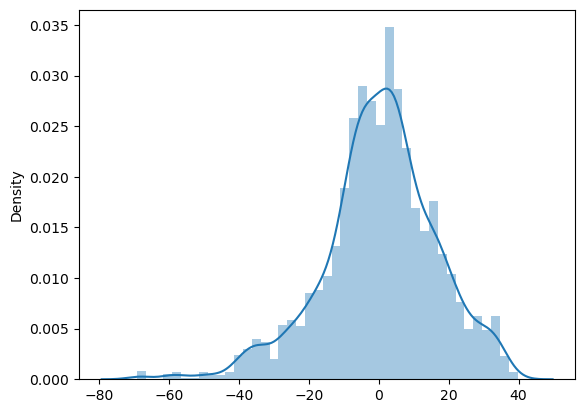

In [27]:
sns.distplot(y_test-prediction_r)

In [28]:
joblib.dump(ridge_regressor,'iplmodel_ridge.sav')

['iplmodel_ridge.sav']